## Working repository 
## updated 12/4/2023

In [1]:
import os
import pandas as pd
from pandas.core.groupby import groupby
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as si
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy
from scipy.stats import linregress
import matplotlib.patches as mpatches
%matplotlib inline
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from matplotlib.ticker import NullFormatter
from matplotlib.dates import MonthLocator, DateFormatter, date2num
import matplotlib.colors as mcolors

In [2]:
df = pd.read_csv('MCW_Processed_Iso_NOV23.csv',parse_dates = [2], infer_datetime_format = True)
df.head()

,Sample Name,Site_ID,Collection_Date,D_2H,D_2H_StDev,D_18O,D_18O_StDev
0,1,BC,2022-10-05,-126.803089,0.905,-16.459499,0.1660
1,2,MC,2022-10-05,-121.245698,0.503,-16.055768,0.0923
2,3,BC,2022-10-27,-124.454618,0.553,-16.515137,0.1370
3,4,MC,2022-10-27,-120.942857,0.834,-15.892233,0.2420
4,5,RC_01,2022-10-27,-92.796701,1.390,-12.540525,0.2320


In [3]:
# From the site ID, just take the first two characters to snow rain, snow, or stream for the type
df['Type'] = df.Site_ID.str[:2]
df['Type'].head(3)

0    BC
1    MC
2    BC
Name: Type, dtype: object

In [4]:
# Take just the site number from the site ID, removing rain or snow labeling
df['Site_no'] = df.Site_ID.str[3:5]
df['Site_no'] = df['Site_no'].to_numpy()
df.tail(3)

,Sample Name,Site_ID,Collection_Date,D_2H,D_2H_StDev,D_18O,D_18O_StDev,Type,Site_no
199,201,RC_08,2023-11-03,-91.974187,0.625,-12.729516,0.2280,RC,08
200,202,BC,2023-11-03,-123.560521,0.748,-16.237848,0.0845,BC,
201,203,MC,2023-11-03,-120.455541,1.060,-16.033286,0.1700,MC,


Colors Codes

In [5]:
rain = 'tomato' #MC only
warm = 'darkorange' #MC only 
snow = 'steelblue'
cold = 'lightsteelblue'
BC_snow = 'teal'
BC_rain = 'peru'

## Rain v Snow
### (IB v RC)

In [6]:
#create new columns with data with isotope values only from rain, snow, and stream 
df['D_18O_Rain'] = np.where(df['Type'] == 'RC', df['D_18O'], np.nan)
df['D_18O_Snow'] = np.where(df['Type'] == 'IB', df['D_18O'], np.nan)
df['D_18O_MC'] = np.where(df['Type'] == 'MC', df['D_18O'],np.nan)
df['D_18O_BC'] = np.where(df['Type'] == 'BC', df['D_18O'], np.nan)

#now create column for std deviation
df['D_18O_std_Rain'] = np.where(df['Type'] == 'RC', df['D_18O_StDev'], np.nan)
df['D_18O_std_Snow'] = np.where(df['Type'] == 'IB', df['D_18O_StDev'], np.nan)

df.head() 

#dont lump stream site, bc and mc seperate
# each calculation is for each collection date for stream samples 

,Sample Name,Site_ID,Collection_Date,D_2H,D_2H_StDev,D_18O,D_18O_StDev,Type,Site_no,D_18O_Rain,D_18O_Snow,D_18O_MC,D_18O_BC,D_18O_std_Rain,D_18O_std_Snow
0,1,BC,2022-10-05,-126.803089,0.905,-16.459499,0.1660,BC,,NaN,NaN,NaN,-16.459499,NaN,NaN
1,2,MC,2022-10-05,-121.245698,0.503,-16.055768,0.0923,MC,,NaN,NaN,-16.055768,NaN,NaN,NaN
2,3,BC,2022-10-27,-124.454618,0.553,-16.515137,0.1370,BC,,NaN,NaN,NaN,-16.515137,NaN,NaN
3,4,MC,2022-10-27,-120.942857,0.834,-15.892233,0.2420,MC,,NaN,NaN,-15.892233,NaN,NaN,NaN
4,5,RC_01,2022-10-27,-92.796701,1.390,-12.540525,0.2320,RC,01,-12.540525,NaN,NaN,NaN,0.232,NaN


In [7]:
std_mean_Rain = df['D_18O_std_Rain'].mean()
print('std Mean Rain = ', std_mean_Rain)

std_mean_Snow = df['D_18O_std_Snow'].mean()
print('std Mean Snow = ', std_mean_Snow)

print('rain mean',df['D_18O_Rain'].mean())

print('snow mean', df['D_18O_Snow'].mean())

print('rain std',df['D_18O_Rain'].std())
print('snow std', df['D_18O_Snow'].std())

std Mean Rain =  0.2003151898734177
std Mean Snow =  0.16103466666666666
rain mean -11.985122468354431
snow mean -19.115825106666666
rain std 2.901118012376055
snow std 2.254428092161091


In [8]:
# Inputs: Summer vs Winter Precipitation
# Outputs: Summer vs Winter Streamflow

# eq 1: qA→M + qB→M = q_M  fluxes
# eq 2: qA→M δA + qB→M δB = q_MδM   isotopic signatures 

#qA→M and qB→M denote fluxes from end-members
#A and B to a mixture M whose total flux is QM

#q_AM = #rain flux
#q_BM = #snow flux 
#q_M = # total flux of mores creek 
#discharge in mm/day

# Isotopic Signatures: δA, δB, and δM 
#without Volume Weights 
delta_rain = df['D_18O_Rain'].mean()
delta_snow = df['D_18O_Snow'].mean()
delta_BC = df['D_18O_BC']
delta_MC = df['D_18O_MC']

delta_stream = df['D_18O']

# f = fraction of A or B that origionates from source M
# eq 3: fM←A = (qA→M / q_M) = (δM − δB) / (δA − δB)
# eq 4: fM←B = 1 − fA = (qB→M / q_M) = (δM − δA) / (δB − δA)

#Overall without seperation of MC and BC
#df['fM_Rain'] = (delta_stream - delta_snow) / (delta_rain - delta_snow)
#df['fM_Snow'] = 1 - df.fM_Rain


#Seperate BC
df['fM_Rain_BC'] = (delta_BC - delta_snow) / (delta_rain - delta_snow)
df['fM_Snow_BC'] = 1 - df.fM_Rain_BC

#Seperate MC
df['fM_Rain_MC'] = (delta_MC - delta_snow) / (delta_rain - delta_snow)
df['fM_Snow_MC'] = 1 - df.fM_Rain_MC

#create BC % Rain 
#createBC % Snow

#vectorize all of BC fraction rain , each D018 value for rain apply equation and calcuate frction of rain and add to data frame
#google multiple every column by 5 
df.head(5)

,Sample Name,Site_ID,Collection_Date,D_2H,D_2H_StDev,D_18O,D_18O_StDev,Type,Site_no,D_18O_Rain,D_18O_Snow,D_18O_MC,D_18O_BC,D_18O_std_Rain,D_18O_std_Snow,fM_Rain_BC,fM_Snow_BC,fM_Rain_MC,fM_Snow_MC
0,1,BC,2022-10-05,-126.803089,0.905,-16.459499,0.1660,BC,,NaN,NaN,NaN,-16.459499,NaN,NaN,0.372520,0.627480,NaN,NaN
1,2,MC,2022-10-05,-121.245698,0.503,-16.055768,0.0923,MC,,NaN,NaN,-16.055768,NaN,NaN,NaN,NaN,NaN,0.429138,0.570862
2,3,BC,2022-10-27,-124.454618,0.553,-16.515137,0.1370,BC,,NaN,NaN,NaN,-16.515137,NaN,NaN,0.364717,0.635283,NaN,NaN
3,4,MC,2022-10-27,-120.942857,0.834,-15.892233,0.2420,MC,,NaN,NaN,-15.892233,NaN,NaN,NaN,NaN,NaN,0.452072,0.547928
4,5,RC_01,2022-10-27,-92.796701,1.390,-12.540525,0.2320,RC,01,-12.540525,NaN,NaN,NaN,0.232,NaN,NaN,NaN,NaN,NaN


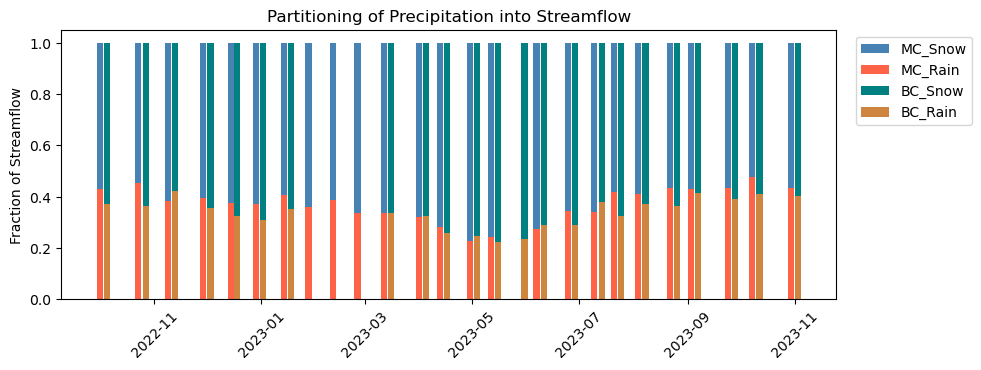

In [9]:
plt.rcParams["figure.figsize"] = [10.00, 3.50]

labels = df['Collection_Date']
width = 3.5

fig, ax = plt.subplots()
x = df['Collection_Date']
x = date2num(x)

rects3 = ax.bar(x-4.15, df.fM_Snow_MC+df.fM_Rain_MC, width, label='MC_Snow', color=snow)
rects1 = ax.bar(x-4.15, df.fM_Rain_MC, width, label='MC_Rain', color= rain)

rects4 = ax.bar(x, df.fM_Snow_BC+df.fM_Rain_BC, width, label='BC_Snow', color=BC_snow)
rects2 = ax.bar(x, df.fM_Rain_BC, width, label='BC_Rain',color=BC_rain)

ax.set_ylabel('Fraction of Streamflow')
ax.set_title("Partitioning of Precipitation into Streamflow")
plt.xticks(rotation=45)
ax.legend(loc='upper center', bbox_to_anchor=(1.1, 1))
ax.xaxis_date()

### Sensativity Analysis
### Cold vs Warm (Below freezing 7+ days)
### Cold seeason = 2022-11-03
### warm Season = 2023-04-22

In [10]:
#Remove stream samples 
df['D_18O_Precip'] = np.where((df['Type'] == 'RC')|
                               (df['Type'] == 'IB'), df['D_18O'], np.nan)
df['D_18O_Precip'].count()

154

In [11]:
# Cold v warm 7+_
df['Cold7'] = np.where((df['Collection_Date'] >= '2022-11-07') &
                        (df['Collection_Date'] < '2023-04-22'), df['D_18O_Precip'], np.nan) 
df['Warm7'] = np.where((df['Collection_Date']  < '2022-11-08') |
                        (df['Collection_Date']  >= '2023-04-23'),df['D_18O_Precip'], np.nan)

print('cold7',df['Cold7'].count())
print('warm7',df['Warm7'].count())

cold7 84
warm7 70


In [15]:
# Isotopic Signatures: δA, δB, and δM 
#without Volume Weights 
delta_Cold7 = df['Cold7'].mean()
delta_Warm7 = df['Warm7'].mean()
print('Warm Avg = ',delta_Warm7)
print('Warm std',df['Warm7'].std())

print('Cold Avg = ',delta_Cold7)
print('Cold std',df['Cold7'].std())

print('rain Avg', delta_rain)
print('snow Avg', delta_snow)

Warm Avg =  -11.531538314285713
Warm std 2.7488323004763133
Cold Avg =  -18.72980804761905
Cold std 2.4275252119201998
rain Avg -11.985122468354431
snow Avg -19.115825106666666


In [13]:
#Seperate MC
df['fM_Warm7_MC'] = (delta_MC - delta_Cold7) / (delta_Warm7 - delta_Cold7)
df['fM_Cold7_MC'] = 1 - df.fM_Warm7_MC

Text(0.5, 1.0, 'Partitioning of Precipitation into Streamflow')

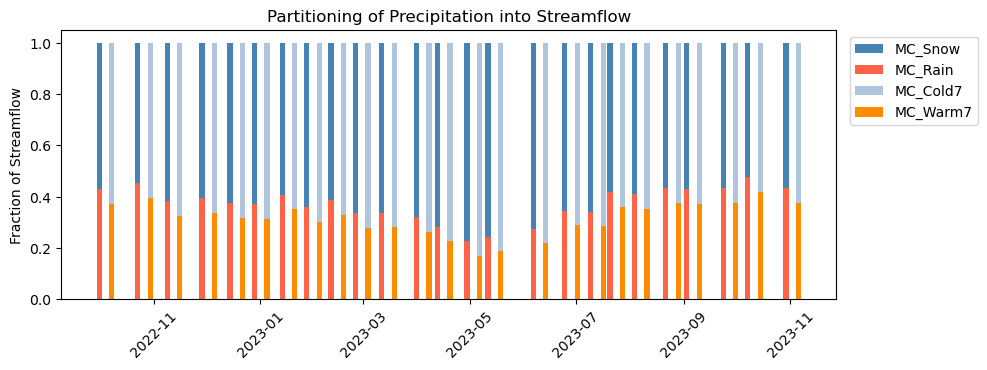

In [14]:
#combine two:

plt.rcParams["figure.figsize"] = [10.00, 3.50]

labels = df['Collection_Date']
#x = np.arange(len(labels))
width = 3

fig, ax = plt.subplots()
x = df['Collection_Date']
x = date2num(x)

# (+/-) to stagger bars 
rects3 = ax.bar(x - 4.5, df.fM_Snow_MC + df.fM_Rain_MC, width, label='MC_Snow', color= snow)
rects1 = ax.bar(x - 4.5, df.fM_Rain_MC, width, label='MC_Rain', color= rain)

rects7 = ax.bar(x + 2.75, df.fM_Cold7_MC + df.fM_Warm7_MC, width, label='MC_Cold7', color=cold)
rects5 = ax.bar(x + 2.75, df.fM_Warm7_MC, width, label='MC_Warm7', color=warm)

ax.set_ylabel('Fraction of Streamflow')
plt.xticks(rotation=45)
#set legend to side of plot
ax.legend(loc='upper center', bbox_to_anchor=(1.1, 1))
ax.xaxis_date()  
ax.set_title("Partitioning of Precipitation into Streamflow")